## Supervised Learning Task
### Lie Group Machine Learning

In [203]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
img_size = 64
labels = ["no_tumor", "pituitary_tumor", "glioma_tumor", "meningioma_tumor"]
folders = ["Training", "Testing"]

x_train = []
y_train = []
for folder in folders:
    for label in labels:
        data_path = os.path.join(".", "archive", folder, label)
        for img_file in tqdm(os.listdir(data_path)):
            img = cv2.imread(os.path.join(data_path, img_file), 0)
            img = cv2.resize(img, (img_size, img_size))
            x_train.append(img)
            y_train.append(label)

for index in range(len(y_train)):
    y_train[index] = labels.index(y_train[index])

# y_train = to_categorical(y_train, len(labels))


x_train, y_train = np.array(x_train), np.array(y_train)
x_train, y_train = shuffle(x_train, y_train, random_state=4)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)
# x_train, x_test = x_train.reshape(len(x_train), -1), x_test.reshape(len(x_test), -1)

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

(64, 64)

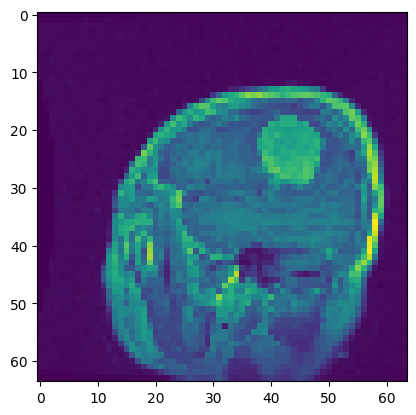

In [204]:
from matplotlib import pyplot
image_test = x_train[3]
pyplot.imshow(image_test)
image_test.shape

In [205]:
rank = np.linalg.matrix_rank(image_test)
U, S, V = np.linalg.svd(image_test)


In [206]:
A = np.zeros((rank,) + image_test.shape)
for i in range(len(S)):
    u, v = U[:, i].reshape(-1, 1), V[i, :].reshape(1, -1)
    A[i] = np.matmul(u, v)


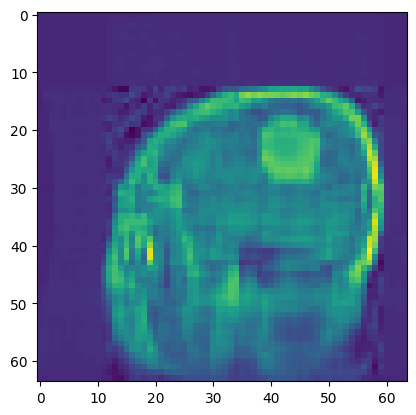

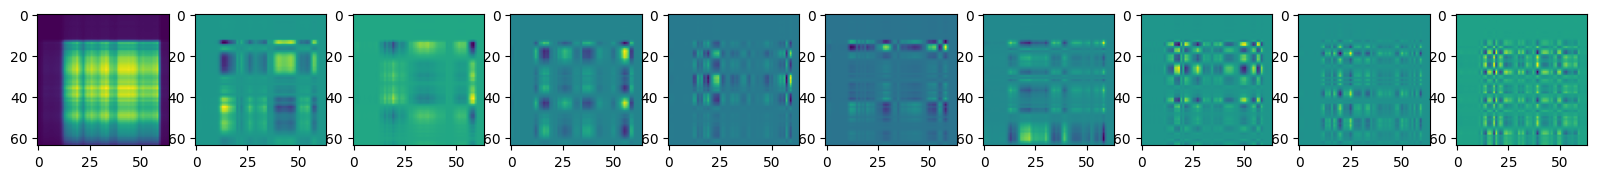

In [207]:
A_processed = np.zeros(image_test.shape)
for i in range(10):
    A_processed += S[i] * A[i]
pyplot.imshow(A_processed)

pyplot.figure(figsize=(20,20))
for i in range(10):
    pyplot.subplot(1, 10, i+1)
    pyplot.imshow(A[i])

In [208]:
def matrix_inner_product(mat_A: np.ndarray, mat_B: np.ndarray):
    #print(mat_A.shape, mat_B.shape)
    return np.trace(np.matmul(mat_A.transpose(),mat_B))

def compute_projection_norm(mat_X, mat_Y_basis):
    projection_norm = 0
    for i in range(len(mat_Y_basis)):
        #print(mat_Y_basis[i].shape)
        projection_norm += matrix_inner_product(mat_X, mat_Y_basis[i])**2
    projection_norm = np.sqrt(projection_norm)
    return projection_norm

def get_basis(mat_X, basis_num):
    mat_rank = np.linalg.matrix_rank(mat_X)
    assert basis_num < mat_rank, "Basis num larger than rank of mat_X"
    mat_U, _, mat_V = np.linalg.svd(mat_X)
    basis = np.zeros((basis_num,) + mat_X.shape)
    for i in range(basis_num):
        u, v = mat_U[:, i].reshape(-1, 1), mat_V[i, :].reshape(1, -1)
        basis[i] = np.matmul(u, v)
    # print(basis.shape)
    return basis

def get_all_basis(train_set, basis_num):
    assert len(train_set.shape) == 4
    class_num, samples_num = train_set.shape[:2]
    basis = np.zeros(train_set.shape[:2] + (basis_num,) + train_set.shape[-2:])
    for class_index in range(class_num):
        for samples_index in range(samples_num):
            basis[class_index, samples_index] = get_basis(train_set[class_index, samples_index], basis_num)
    return basis

def determinate_function(mat_X, samples, basis_num):
    samples_num = len(samples)
    determinate_values = np.zeros(samples_num)
    for i in range(samples_num):
        #print(samples.shape)
        determinate_values[i] = compute_projection_norm(mat_X, get_basis(samples[i], basis_num))
    return np.max(determinate_values)

Get a small portion of training set

2616.716506058222
2595.0783698147675
2737.7718110973306
2661.8302582348547
2


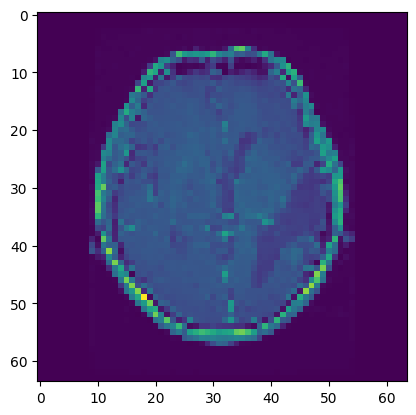

In [209]:
samples_num_each_class = 400
train_set_experiment = np.zeros((len(labels), samples_num_each_class, ) + (img_size, img_size))
for class_index in range(len(labels)):
    x_train_class = x_train[y_train==class_index]
    random_index = np.random.choice(x_train_class.shape[0], samples_num_each_class)
    train_set_experiment[class_index] = x_train_class[random_index]

test_image = x_test[100]
pyplot.imshow(test_image)
for class_index in range(len(labels)):
    print(determinate_function(test_image, train_set_experiment[class_index], 20))
print(y_test[100])

In [210]:
basis = get_all_basis(train_set_experiment, 20)
basis.shape

def determinate_function(mat_X, class_index, basis):
    determinate_values = np.zeros(basis.shape[1])
    for i in range(basis.shape[1]):
        #print(samples.shape)
        determinate_values[i] = compute_projection_norm(mat_X, basis[class_index, i])
    return np.max(determinate_values)

def predict(test_images, basis):
    class_predicted = np.zeros(test_images.shape[0], dtype=int)
    for image_index in tqdm(range(test_images.shape[0])):
        score = np.zeros(basis.shape[0])
        for class_index in range(basis.shape[0]):
            score[class_index] = determinate_function(test_images[image_index], class_index, basis)
        class_predicted[image_index] = np.argmax(score)
    return class_predicted

def score(x_test, y_test, basis):
    y_test_predicted = predict(x_test, basis)
    

In [212]:
# determinate_function(test_image, 1, basis)
y_test_predicted = predict(x_test[:50], basis)
print(y_test_predicted)
print(y_test[:50])
# x_test.shape
np.sum(y_test_predicted == y_test[:50])/50

  0%|          | 0/50 [00:00<?, ?it/s]

[2 2 1 2 1 1 3 2 2 3 2 2 2 1 1 1 2 0 1 3 2 2 3 1 1 2 2 0 1 2 1 0 0 1 2 2 2
 1 0 0 1 1 1 3 0 3 2 2 1 0]
[2 2 1 2 1 1 3 0 2 3 2 2 2 2 1 1 0 0 1 3 2 2 3 1 1 2 2 0 1 2 1 0 0 1 2 2 2
 1 0 3 1 1 1 3 0 3 2 2 1 0]


0.92